In [1]:
import IPython

# Manipulation

This tutorial describes how manipulation is performed by our domestic robots. All examples in this tutorial will refer to the Toyota Human Support Robot.

## List of contents

1. [Manipulation: The `move_arm` Action](#Manipulation:-The-move_arm-Action)
2. [`move_arm` in Action](#move_arm-in-Action)
3. [Dynamic Motion Primitives](#Dynamic-Motion-Primitives-%28DMPs%29)
    1. [DMP Primer](#DMP-Primer)
    2. [Learning Motion Primitives](#Learning-Motion-Primitives)
        1. [Trajectory Demonstration](#Trajectory-Demonstration)
        2. [Learning the Weights of the Motion Primitive](#Learning-the-Weights-of-the-Motion-Primitive)
        3. [Using a DMP](#Using-a-DMP)
        4. [Tuning the DMP Parameters](#Tuning-the-DMP-Parameters)
5. [Arm Motion Use Cases](#Arm-Motion-Use-Cases)
    1. [Picking Up Objects](#Picking-Up-Objects)
    2. [Placing Objects](#Placing-Objects)

## Manipulation: The `move_arm` Action

To perform manipulation and in line with our skill-based domestic robot architecture, we use a `move_arm` action that exposes a high-level interface for controlling a robot arm (under the assumption that there is a single robot arm). The `move_arm` action allows controlling the arm in three different ways:
1. the arm joints can be sent to a predefined named configuration (e.g `folded`) using MoveIt!
2. the end effector can be sent to a desired pose with respect to a given coordinate frame; the arm motion can be performed either using MoveIt! or with a dynamic motion primitive
3. the joint positions can be set arbitrarily; once again, the motion will be performed using MoveIt!

The way in which the arm is controlled can be selected by setting the `goal_type` parameter of the action, such that the additional parameters that have to be passed to the action depend on the goal type. Please refer to the [documentation](https://github.com/b-it-bots/mas_domestic_robotics/tree/kinetic/mdr_planning/mdr_actions/mdr_manipulation_actions/mdr_move_arm_action) of the action for the action specification.

Note that the named joint configurations need to be specified in the MoveIt! configuration file for a specific robot (for the Toyota HSR, they are in the `hsrb.srdf` file in the `hsrb_moveit_config` package).

## `move_arm` in Action

We can now illustrate how arm motions can be performed. Let us first start the simulation of the Toyota HSR:

```
roslaunch mas_hsr_sim hbrs-c069.launch
```

This should result in the following Rviz output:

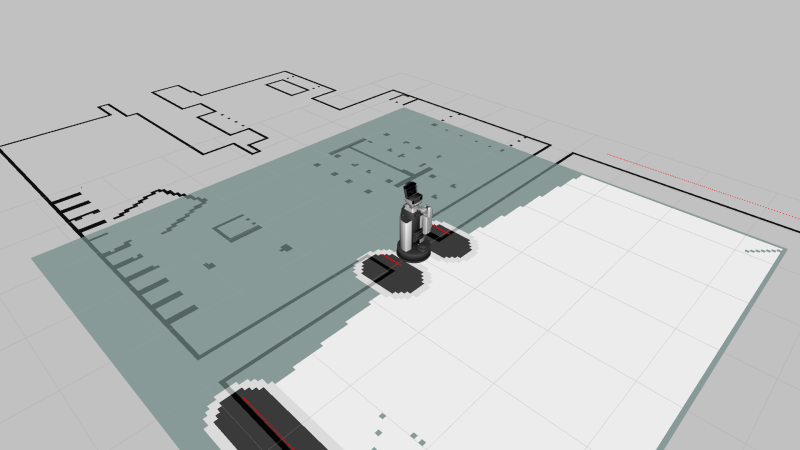

In [2]:
IPython.core.display.Image('images/hsr_sim_hbrs_c069.png', embed=True)

Once the simulation has started, we need to start the server for the `move_arm` action:

```
roslaunch mas_hsr_move_arm_action move_arm.launch 
```

Let's now set up a client for the action:

In [ ]:
import rospy
import actionlib
from mdr_move_arm_action.msg import MoveArmAction, MoveArmGoal

# we set an arbitrary timeout for the action
action_timeout = 15.

rospy.init_node('move_arm_client_test')

client = actionlib.SimpleActionClient('/move_arm_server', MoveArmAction)
client.wait_for_server()

Let's assume that we want to send the arm to the $(x,y,z) = (0.4, 0.078, 0.8)m$ with orientation $(x,y,z) = (0, 0, 0)$ with respect to the `base_link` frame using MoveIt! The following code snippet (adapted from the [move_arm_action_client_test](https://github.com/b-it-bots/mas_domestic_robotics/blob/kinetic/mdr_planning/mdr_actions/mdr_manipulation_actions/mdr_move_arm_action/ros/scripts/move_arm_action_client_test) script) will do just that:

In [ ]:
from geometry_msgs.msg import PoseStamped

goal = MoveArmGoal()
goal.goal_type = MoveArmGoal.END_EFFECTOR_POSE

pose = PoseStamped()
pose.header.frame_id = 'base_link'

pose.pose.position.x = 0.4
pose.pose.position.y = 0.078 # hsr-specific arm offset
pose.pose.position.z = 0.8

pose.pose.orientation.x = 0.
pose.pose.orientation.y = 0.
pose.pose.orientation.z = 0.
pose.pose.orientation.w = 1.

goal.end_effector_pose = pose

# empty if we want to use MoveIt! rather than a DMP for moving the arm
goal.dmp_name = ''

client.send_goal(goal)
client.wait_for_result(rospy.Duration.from_sec(int(action_timeout)))

result = client.get_result()
if result and result.success:
    print('Arm moved successfully')
else:
    print('Could not move the arm')

If we want to send the arm to a predefined joint configuration instead of sending the end effector to a given pose, we can call the action as follows:

In [ ]:
goal = MoveArmGoal()
goal.goal_type = MoveArmGoal.NAMED_TARGET
goal.named_target = 'go'

client.send_goal(goal)
client.wait_for_result(rospy.Duration.from_sec(int(action_timeout)))

result = client.get_result()
if result and result.success:
    print('Arm moved successfully')
else:
    print('Could not move the arm')

## Dynamic Motion Primitives (DMPs)

For the purpose of easier setup and portability, our robots have traditionally used [MoveIt!](https://moveit.ros.org) as a manipulation framework. As described above, our `move_arm` action uses MoveIt! as well, but not exclusively, such that we additionally make use of dynamic motion primitives [1].

MoveIt! generally uses randomised planners for finding motion trajectories for a robot manipulator. This offers flexibility in the motion planning process; however, randomised planners often result in trajectories that are unpredictable or suboptimal (e.g. with respect to the distance travelled). Dynamic motion primitives on the other hand encode trajectories that a manipulator will then try to reproduce during its motion; one benefit of this is that resulting trajectories are more predictable and often more natural.

### DMP Primer

In the DMP framework [1], trajectories are represented by a second-order differential equation of the form

\begin{equation*}
    \tau \ddot{\mathbf{y}} = \alpha(\beta(\mathbf{g} - \mathbf{y}) - \dot{\mathbf{y}}) + \mathbf{f}
\end{equation*}

In this equation, $\mathbf{y}$ is the state of the system (usually the 3D Cartesian pose of the robot), $\mathbf{g}$ is the desired end effector pose, $\tau$ is a parameter that adjusts the trajectory duration, while $\alpha$ and $\beta$ are positive constants (please consult [these very nice lecture notes](http://tutorial.math.lamar.edu/Classes/DE/Vibrations.aspx) if you need a refresher on second-order differential equations and spring-mass-damper systems in particular).

A common use for DMPs is to encode trajectories that have been demonstrated to a robot, such that the goal in this case is finding a representation for $\mathbf{f}$ that will represent the demonstrated trajectory as closely as possible; the forcing term should however eventually vanish so that the trajectory can converge to the desired goal. In [1], which is what our implementation is based on, the forcing term is represented as

\begin{equation*}
    f_j(t) = \frac{\sum_{i=1}^{N}\Psi_{i,j}(t)w_{i,j}}{\sum_{i=1}^{N}\Psi_{i,j}(t)}
\end{equation*}

where the $\Psi_{i,j}$ are exponential basis functions and the $w_{i,j}$ are weighting terms for the individual basis functions.

We demonstrate trajectories by moving a marker array and recording the observations of the marker using a robot's camera (a video illustrating the demonstration process can be found at https://www.youtube.com/watch?v=jEtlm96KAbA); given a demonstration of the trajectory, we can learn the trajectory weights and then use them for execution. The learning process is described next.

[1] A. J. Ijspeert, J. Nakanishi, H. Hoffmann, P. Pastor, and S. Schaal, “Dynamical Movement Primitives: Learning Attractor Models for Motor Behaviors,” Neural Computation, vol. 25, no. 2, pp. 328-373, 2013. Available: https://homes.cs.washington.edu/~todorov/courses/amath579/reading/DynamicPrimitives.pdf

### Learning Motion Primitives

The process of learning a DMP involves two steps, namely

1. a trajectory demonstration needs to be performed and
2. given the demonstrated trajectory, the weights of the DMP need to be learned

#### Trajectory Demonstration

To learn a motion primitive, we first need to demonstrate a trajectory and record it; the [`demonstrated_trajectory_recorder`](https://github.com/abhishek098/demonstrated_trajectory_recorder/tree/master) package has been designed for that purpose. For recording a trajectory, we need to launch the trajectory recording node:

```
roslaunch demonstrated_trajectory_recorder demo.launch
```

The command line instructions can then be followed for starting the recording. After that, the trajectory needs to be demonstrated by moving the marker rray in front of the robot's camera (it is clearly important that the marker array remains visible throughout the demonstration). Once the demonstration is over, the recording can be stopped; the trajectory will then be saved to a YAML file with a name specified on the command line under `<path-to-demonstrated_trajectory_recorder>/data/file_name.yaml`.

#### Learning the Weights of the Motion Primitive

To learn the weights of the motion primitive, we need to use the functionalities in the [`ros_dmp`](https://github.com/abhishek098/ros_dmp/blob/whole_body_motion/src/learn_motion_primitive.py) package - currently on the `whole_body_motion` branch). Before proceeding with the learning step, we need to copy over the demonstrated trajectory to `<path-to-ros_dmp>/data/trajectories/old_trajectories/`. We can now learn the weights by running the learning script (which is under `ros_dmp/src`:

```
python learn_motion_primitive.py
```

The learning script will ask for the name of the trajectory file (just the name of the file, not the path); the DMP weights will then be saved to a YAML file under `<path-to-ros_dmp>/data/weights/weights_<trajectory_file_name>`.

#### Using a DMP

To use a DMP in the `move_arm` action, the path to the DMP should be passed as value for the `dmp_name` parameter of the action goal. By passing this parameter, MoveIt! will not be used for motion, but the trajectory represented by the DMP will be executed instead. As mentioned at the beginning of this tutorial, DMPs can only be used when moving the end effector to a specified pose.

**Note 1**: The implementation of the component that takes care of executing a trajectory represented by a DMP is [inside the `move_arm` action](https://github.com/b-it-bots/mas_domestic_robotics/blob/devel/mdr_planning/mdr_actions/mdr_manipulation_actions/mdr_move_arm_action/ros/src/mdr_move_arm_action/dmp.py); however, as mentioned before, the trajectory represented by the DMP is for the end effector and not in the joint space. The implementation of the inverse kinematics solver that actually allows a manipulator to follow the trajectory can be found in the [`mcr_arm_cartesian_control` package](https://github.com/b-it-bots/mas_common_robotics/tree/kinetic/mcr_manipulation/mcr_arm_cartesian_control).

**Note 2**: Due to limitations in the current implementation, we can only reliably reproduce trajectories with a sideways approach vector; top-down approach vectors are not guaranteed to work well.

#### Tuning the DMP Parameters

When using the `move_arm` action with a learned DMP, users can only set the $\tau$ parameter - `dmp_tau` is one of the action goal parameters - which controls the duration of motion, but also the accuracy of execution: a value of $1$ means that the velocity will match the velocity of the demonstration, while higher values will increase the velocity, but may cause oscillations and inaccuracies in reaching a goal. For the HSR robot, $\tau = 30$ has been found to provide a good balance between accuracy and speed.

During learning, another important parameter is $N$, the number of basis function used for representing the DMP forcing term. A small number of basis function generally leads to a crude representation of the demonstrated trajectory, but reduces the computational cost during reproduction. On the other hand, a large number of basis functions increases the accuracy of the representation, but also the complexity of the reproduction; in addition, a value of $N$ that is very high will lead to learning the noise in the demonstrated trajectory. For these reasons, the value of $N$ is best determined experimentally and may need to vary from trajectory to trajectory, such that values $N = 300$ or $N = 500$ may be good initial guesses.

## Arm Motion Use Cases


### Picking Up Objects

```
roslaunch mas_hsr_move_arm_action move_arm.launch
```

```
roslaunch mas_hsr_move_base_action move_base.launch
```

```
roslaunch mas_hsr_move_arm_joints_action move_arm_joints.launch
```

```
roslaunch mas_hsr_move_forward_action move_forward.launch
```

```
roslaunch mas_hsr_pickup_action pickup_action.launch
```

```
rosrun mdr_pickup_action pickup_action_client_test
```

### Placing Objects

```
roslaunch mas_hsr_move_arm_action move_arm.launch
```

```
roslaunch mas_hsr_move_base_action move_base.launch
```

```
roslaunch mas_hsr_move_arm_joints_action move_arm_joints.launch
```

```
roslaunch mas_hsr_move_forward_action move_forward.launch
```

```
roslaunch mas_hsr_place_action place_action.launch
```

```
rosrun mdr_place_action place_action_client_test
```

## About This Tutorial

**Author(s)**: Alex Mitrevski

**Last update**: 23.02.2019